In [1]:
import tensorflow as tf

mnist = tf.keras.datasets.mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [2]:

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.initializers import he_uniform
from tensorflow.keras.initializers import glorot_uniform


img_A_inp = Input((28, 28), name='img_A_inp')
img_B_inp = Input((28, 28), name='img_B_inp')

def get_cnn_block(depth):
    return Sequential([Conv2D(depth, 3, 1, kernel_initializer=glorot_uniform()),
                       BatchNormalization(),
                       ReLU()])

DEPTH = 64
cnn = Sequential([Reshape((28, 28, 1)),
                  get_cnn_block(DEPTH),
                  get_cnn_block(DEPTH*2),
                  get_cnn_block(DEPTH*4),
                  get_cnn_block(DEPTH*8),
                  GlobalAveragePooling2D(),
                  Dense(64, activation='relu')])

feature_vector_A = cnn(img_A_inp)
feature_vector_B = cnn(img_B_inp)

concat = Concatenate()([feature_vector_A, feature_vector_B])

dense = Dense(64, activation='relu')(concat)
dense1 = Dense(128, activation='relu')(dense)
output = Dense(1, activation='sigmoid')(dense1)

model = Model(inputs=[img_A_inp, img_B_inp], outputs=output)

model.summary()
# Get the number of layers in the model
num_layers = len(model.layers)

print("Number of layers in the CNN:", num_layers)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img_A_inp (InputLayer)         [(None, 28, 28)]     0           []                               
                                                                                                  
 img_B_inp (InputLayer)         [(None, 28, 28)]     0           []                               
                                                                                                  
 sequential_4 (Sequential)      (None, 64)           1586496     ['img_A_inp[0][0]',              
                                                                  'img_B_inp[0][0]']              
                                                                                                  
 concatenate (Concatenate)      (None, 128)          0           ['sequential_4[0][0]',       

In [3]:
import numpy as np

random_indices = np.random.choice(X_train.shape[0], 100, replace=False)

X_train_sample, y_train_sample = X_train[random_indices], y_train[random_indices]

X_train_sample.shape, y_train_sample.shape

len(X_train_sample) ** 2

10000

In [4]:
import itertools

def make_paired_dataset(X, y):
  X_pairs, y_pairs = [], []

  tuples = [(x1, y1) for x1, y1 in zip(X, y)]
  
  for t in itertools.product(tuples, tuples):
    pair_A, pair_B = t
    img_A, label_A = t[0]
    img_B, label_B = t[1]

    new_label = int(label_A == label_B)

    X_pairs.append([img_A, img_B])
    y_pairs.append(new_label)
  
  X_pairs = np.array(X_pairs)
  y_pairs = np.array(y_pairs)

  return X_pairs, y_pairs

In [5]:
make_paired_dataset(X_train_sample, y_train_sample)

(array([[[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],
 
         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]]],
 
 
        [[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],
 
         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]]],
 
 
        [[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0

In [6]:
X_train_pairs, y_train_pairs = make_paired_dataset(X_train_sample, y_train_sample)

X_train_pairs.shape, y_train_pairs.shape

((10000, 2, 28, 28), (10000,))

In [7]:
random_indices = np.random.choice(X_test.shape[0], 50, replace=False)

X_test_sample, y_test_sample = X_test[random_indices], y_test[random_indices]

X_test_sample.shape, y_test_sample.shape

((50, 28, 28), (50,))

In [8]:

X_test_pairs, y_test_pairs = make_paired_dataset(X_test_sample, y_test_sample)

X_test_pairs.shape, y_test_pairs.shape

((2500, 2, 28, 28), (2500,))

In [9]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=3)

In [11]:
model.fit(x=[X_train_pairs[:, 0, :, :], X_train_pairs[:, 1, :, :]],
          y=y_train_pairs,
          validation_data=([X_test_pairs[:, 0, :, :], 
                            X_test_pairs[:, 1, :, :]],
                           y_test_pairs),
          epochs=10,
          batch_size=1024,
          callbacks=[es])

Epoch 1/10
10/10 [==============================] - 694s 70s/step - loss: 0.4106 - accuracy: 0.8641 - val_loss: 0.6801 - val_accuracy: 0.8896
Epoch 2/10
10/10 [==============================] - 574s 58s/step - loss: 0.3444 - accuracy: 0.8896 - val_loss: 0.7854 - val_accuracy: 0.8896
Epoch 3/10
10/10 [==============================] - 627s 64s/step - loss: 0.3336 - accuracy: 0.8896 - val_loss: 0.5260 - val_accuracy: 0.8896
Epoch 4/10
10/10 [==============================] - 676s 68s/step - loss: 0.3180 - accuracy: 0.8896 - val_loss: 0.4050 - val_accuracy: 0.8896
Epoch 5/10
10/10 [==============================] - 667s 68s/step - loss: 0.2985 - accuracy: 0.8896 - val_loss: 0.3220 - val_accuracy: 0.8896
Epoch 6/10
10/10 [==============================] - 693s 70s/step - loss: 0.2811 - accuracy: 0.8927 - val_loss: 0.3123 - val_accuracy: 0.8900
Epoch 7/10
10/10 [==============================] - 703s 71s/step - loss: 0.2619 - accuracy: 0.9006 - val_loss: 0.3625 - val_accuracy: 0.8896
Epoch 

In [12]:
img_A, img_B = X_test[0], X_test[17]
label_A, label_B = y_test[0], y_test[17]

label_A, label_B

(7, 7)

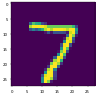

In [13]:

import matplotlib.pyplot as plt

plt.figure(dpi=28)
plt.imshow(img_A)

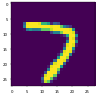

In [14]:

plt.figure(dpi=28)
plt.imshow(img_B)

In [15]:

model.predict([img_A.reshape((1, 28, 28)), 
               img_B.reshape((1, 28, 28))]).flatten()[0] > 0.5



False